In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
sys.path.append('../src/')
import progan as pgan
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
#from matplotlib import gridspec as grid
mpl.rcParams['axes.facecolor'] = '.8'
mpl.rcParams['figure.facecolor'] = '.3'

import cv2
from tqdm import tqdm as tqdm
from IPython.display import clear_output

# import logging
# logging.basicConfig(level=logging.WARNING)

import warnings
warnings.simplefilter('ignore')

from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator

from tools import plot_epoch, load_img_gen, plot_samples

# MODEL

In [80]:
# IMG_SHAPE_LIST =    [4, 8, 16,32, 64,128,256]
# FILTER_SHAPE_LIST = [512, 256, 128, 64, 32, 16, 8]

IMG_SHAPE_LIST =    [ 8,  16, 32, 64]
FILTER_SHAPE_LIST = [32, 16, 8, 8]

LATENT_DIM = 100
OPTIMIZER = Adam(0.005, 0.5, clipvalue=1)
#OPTIMIZER = Adam(0.0001, 0, 0.99, epsilon=10e-8, clipvalue=1)
#OPTIMIZER = Adam()

In [81]:
prog = pgan.PROG_GAN(IMG_SHAPE_LIST, FILTER_SHAPE_LIST, 3, LATENT_DIM, OPTIMIZER)
prog.build_model()

Number of stacked levels: 0
Image shape: (8, 8, 3)


In [87]:
prog.add_level()

Number of stacked levels: 1
Image shape: (16, 16, 3)


 - Constant alpha
 - Constant data subsample




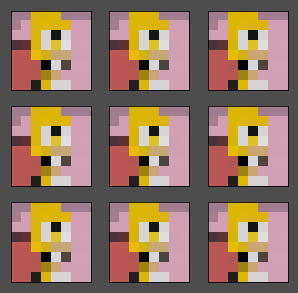

In [82]:
EPOCHS = 5000
BATCH_SIZE = 32
PATH = '../data/Simpsons/'

MODE = 'test'
ALPHA = 'const_0.5'

level = prog.level
size = prog.get_layer_img_shape(level)[0]

if ALPHA == 'lin':
    alpha = np.linspace(0, 1, EPOCHS)[::-1]
    print(' - Linearly changing alpha')
    
elif ALPHA.startswith('const'):
    const = 0
    _ = ALPHA.find('_')
    if _ != -1:
        const = float(ALPHA[_+1:])
    alpha = const*np.ones(EPOCHS)
    print(' - Constant alpha')

if MODE == 'train':
    data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=60,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,
                     rescale=1.0/255.0)

    img_gen = ImageDataGenerator(**data_gen_args).flow_from_directory(PATH, target_size=(size,size),
                                batch_size=BATCH_SIZE, class_mode=None)
    print(' - Dynamicly augmented data')
    
elif MODE == 'test':
    img_gen = load_img_gen(PATH, size, BATCH_SIZE)
    print(' - Constant data subsample')

print('\n')
plot_samples(img_gen)

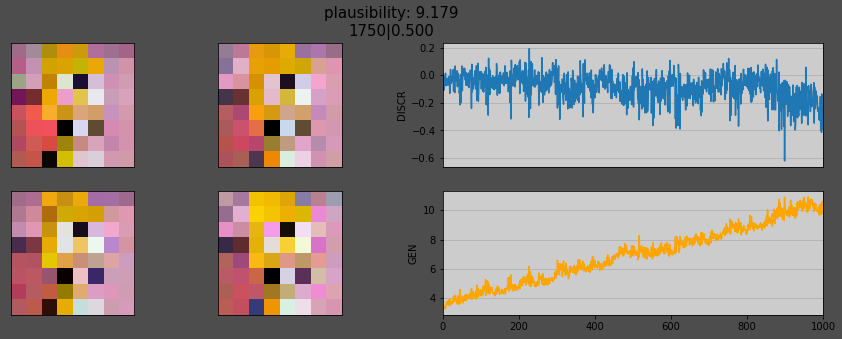

INTERRUPTED
CPU times: user 1min 48s, sys: 19.1 s, total: 2min 7s
Wall time: 47.8 s


In [83]:
%%time
try:
    for epoch in range(1, EPOCHS):
        a = alpha[epoch]
        real_X = next(img_gen)
        prog.train(real_X, alpha=a) # alpha(epoch, 0.25)
        if epoch % 50 == 0:
            clear_output(True)
            plot_epoch(prog, a, 1000)
            
except KeyboardInterrupt:
    print('INTERRUPTED')
alpha = np.zeros(EPOCHS)

# VALIDATION

In [84]:
print('GEN:')
print(np.mean([prog.get_comb_proba(alpha=a)[0][0] for _ in range(100)]))

print('\nREAL:')
print(np.mean(prog.get_proba(next(img_gen), a)))

GEN:
10.009289

REAL:
7.907499


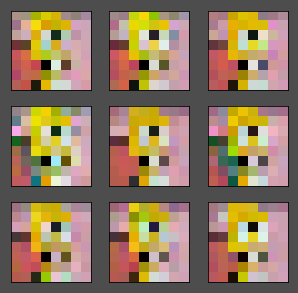

In [85]:
noise = np.random.normal(0,1,(9, LATENT_DIM))
img = iter([prog.generate(noise, a)])
plot_samples(img)

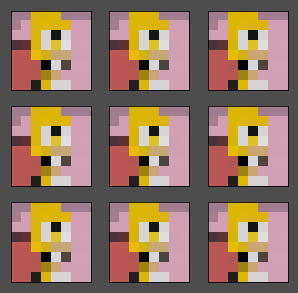

In [86]:
plot_samples(img_gen)

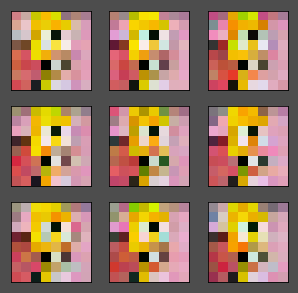

In [35]:
noise = np.random.normal(0,1,(9, LATENT_DIM))
img = iter([prog.generate(noise, 1)])
plot_samples(img)